In [1]:
import os
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
torch.manual_seed(8)

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
# from tensorboardX import SummaryWriter
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
#then import my own modules
from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight

RDKit WARNING: [01:47:46] Enabling RDKit 2019.09.3 jupyter extensions
[01:47:46] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
from rdkit.Chem import rdMolDescriptors, MolSurf
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.cm as cm
import matplotlib
import seaborn as sns; sns.set_style("darkgrid")
from IPython.display import SVG, display
import sascorer
import itertools
from sklearn.metrics import r2_score
import scipy

In [3]:
random_seed = 108 
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

batch_size = 200
epochs = 200

p_dropout= 0.2
fingerprint_dim = 200

weight_decay = 5 # also known as l2_regularization_lambda
learning_rate = 2.5
output_units_num = 1 # for regression model
radius = 2
T = 2

number of all smiles:  1128
number of successfully processed smiles:  1128


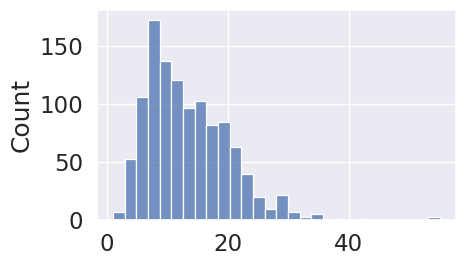

In [4]:
task_name = 'solubility'
tasks = ['measured log solubility in mols per litre']

raw_filename = "../data/delaney-processed.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print(smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]
# print(smiles_tasks_df)
smiles_tasks_df['cano_smiles'] =canonical_smiles_list

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.histplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
# plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()


In [5]:
if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)
# feature_dicts = get_smiles_dicts(smilesList)
remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
print("not processed items")
uncovered_df

not processed items


,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,cano_smiles
934,Methane,-0.636,0,16.043,0,0,0,0.0,-0.9,C,C


In [6]:
remained_df = remained_df.reset_index(drop=True)
test_df = remained_df.sample(frac=1/10, random_state=random_seed) # test set
training_data = remained_df.drop(test_df.index) # training data

# training data is further divided into validation set and train set
valid_df = training_data.sample(frac=1/9, random_state=random_seed) # validation set
train_df = training_data.drop(valid_df.index) # train set
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# print(len(test_df),sorted(test_df.cano_smiles.values))


In [7]:
test_df

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,cano_smiles
0,1-Chlorobutane,-1.940,1,92.569,0,0,2,0.00,-2.03,CCCCCl,CCCCCl
1,"2,6-Dimethylphenol",-2.589,1,122.167,1,1,0,20.23,-1.29,Cc1cccc(C)c1O,Cc1cccc(C)c1O
2,RTI 24,-4.423,1,273.723,1,3,1,45.23,-5.36,CCN2c1cc(Cl)ccc1NC(=O)c3cccnc23,CCN1c2cc(Cl)ccc2NC(=O)c2cccnc21
3,1-Dodecanol,-3.523,1,186.339,1,0,10,20.23,-4.80,CCCCCCCCCCCCO,CCCCCCCCCCCCO
4,3-Pentanol,-0.970,1,88.150,1,0,2,20.23,-0.24,CCC(O)CC,CCC(O)CC
...,...,...,...,...,...,...,...,...,...,...,...
108,p-Hydroxybenzaldehyde,-2.003,1,122.123,1,1,1,37.30,-0.96,Oc1ccc(C=O)cc1,O=Cc1ccc(O)cc1
109,Propyl propanoate,-1.545,1,116.160,0,0,3,26.30,-1.34,CCCCC(=O)OC,CCCCC(=O)OC
110,Methylcyclopentane,-2.452,1,84.162,0,1,0,0.00,-3.30,CC1CCCC1,CC1CCCC1
111,Dimethyldisulfide,-1.524,1,94.204,0,0,1,0.00,-1.44,CSSC,CSSC


In [8]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([canonical_smiles_list[0]],feature_dicts)
num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]
loss_function = nn.MSELoss()
model = Fingerprint(radius, T, num_atom_features, num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()

# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
# optimizer = optim.SGD(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)

# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

863604
atom_fc.weight torch.Size([200, 39])
atom_fc.bias torch.Size([200])
neighbor_fc.weight torch.Size([200, 49])
neighbor_fc.bias torch.Size([200])
GRUCell.0.weight_ih torch.Size([600, 200])
GRUCell.0.weight_hh torch.Size([600, 200])
GRUCell.0.bias_ih torch.Size([600])
GRUCell.0.bias_hh torch.Size([600])
GRUCell.1.weight_ih torch.Size([600, 200])
GRUCell.1.weight_hh torch.Size([600, 200])
GRUCell.1.bias_ih torch.Size([600])
GRUCell.1.bias_hh torch.Size([600])
align.0.weight torch.Size([1, 400])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 400])
align.1.bias torch.Size([1])
attend.0.weight torch.Size([200, 200])
attend.0.bias torch.Size([200])
attend.1.weight torch.Size([200, 200])
attend.1.bias torch.Size([200])
mol_GRUCell.weight_ih torch.Size([600, 200])
mol_GRUCell.weight_hh torch.Size([600, 200])
mol_GRUCell.bias_ih torch.Size([600])
mol_GRUCell.bias_hh torch.Size([600])
mol_align.weight torch.Size([1, 400])
mol_align.bias torch.Size([1])
mol_attend.weight torch.Si

In [9]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.cano_smiles.values
        y_val = batch_df[tasks[0]].values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        
        model.zero_grad()
        loss = loss_function(mol_prediction, torch.Tensor(y_val).view(-1,1))     
        loss.backward()
        optimizer.step()
def eval(model, dataset):
    model.eval()
    test_MAE_list = []
    test_MSE_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch) 
    for counter, test_batch in enumerate(batch_list):
        batch_df = dataset.loc[test_batch,:]
        smiles_list = batch_df.cano_smiles.values
#         print(batch_df)
        y_val = batch_df[tasks[0]].values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        MAE = F.l1_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')        
        MSE = F.mse_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')
#         print(x_mask[:2],atoms_prediction.shape, mol_prediction,MSE)
        
        test_MAE_list.extend(MAE.data.squeeze().cpu().numpy())
        test_MSE_list.extend(MSE.data.squeeze().cpu().numpy())
    return np.array(test_MAE_list).mean(), np.array(test_MSE_list).mean()


In [10]:
best_param ={}
best_param["train_epoch"] = 0
best_param["valid_epoch"] = 0
best_param["train_MSE"] = 9e8
best_param["valid_MSE"] = 9e8

for epoch in range(800):
    train_MAE, train_MSE = eval(model, train_df)
    valid_MAE, valid_MSE = eval(model, valid_df)
#     tensorboard.add_scalars('MAE',{'train_MAE':valid_MAE, 'test_MAE':valid_MSE}, epoch)
#     tensorboard.add_scalars('MSE',{'train_MSE':valid_MAE, 'test_MSE':valid_MSE}, epoch)
    if train_MSE < best_param["train_MSE"]:
        best_param["train_epoch"] = epoch
        best_param["train_MSE"] = train_MSE
    if valid_MSE < best_param["valid_MSE"]:
        best_param["valid_epoch"] = epoch
        best_param["valid_MSE"] = valid_MSE
        if valid_MSE < 0.35:
             torch.save(model.state_dict(), 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
    if (epoch - best_param["train_epoch"] >8) and (epoch - best_param["valid_epoch"] >10):        
        break
    print(epoch, np.sqrt(train_MSE), np.sqrt(valid_MSE))
    
    train(model, train_df, optimizer, loss_function)


0 3.8014205 3.9279873


1 2.48021 2.5133314


2 1.7527528 1.7144762


3 1.7473387 1.711951


4 1.7267344 1.714163


5 1.5874865 1.5941757


6 1.4875368 1.494886


7 1.3260889 1.3223579


8 1.1743022 1.1067135


9 1.0412709 1.0653037


10 0.94647485 0.99059254


11 0.889376 0.8897153


12 0.89395124 0.903725


13 0.8709084 0.80352384


14 0.7821883 0.7764976


15 0.7748484 0.79919827


16 0.7665218 0.79939336


17 0.76462984 0.8271224


18 0.70027703 0.71901846


19 0.7121906 0.7233076


20 0.65505135 0.7054871


21 0.64503866 0.69997984


22 0.6252111 0.6798236


23 0.62537026 0.6749331


24 0.6182824 0.6940306


25 0.6087324 0.6717252


26 0.60175955 0.7004521


27 0.601762 0.6694709


28 0.6112938 0.6622765


29 0.6132817 0.65430146


30 0.6115841 0.65667844


31 0.5670414 0.6591522


32 0.56567657 0.65285015


33 0.55153996 0.6259061


34 0.5536429 0.63277495


35 0.54218304 0.63319737


36 0.52836204 0.62058103


37 0.5210519 0.6266766


38 0.5166251 0.597658


39 0.52267843 0.63396597


40 0.5275616 0.6118134


41 0.50778174 0.61761475


42 0.49632737 0.6206004


43 0.48958004 0.57850134


44 0.4924261 0.60229594


45 0.5033259 0.5871272


46 0.51102954 0.59587705


47 0.5008369 0.60195917


48 0.4697879 0.5823859


49 0.50973725 0.65645117


50 0.46763825 0.5884561


51 0.5774328 0.6376971


52 0.48201057 0.5690086


53 0.4599877 0.5767635


54 0.45911738 0.55082935


55 0.50825113 0.5872432


56 0.4722209 0.56537235


57 0.459597 0.5682243


58 0.434112 0.5713472


59 0.45070875 0.5628933


60 0.4555409 0.57477343


61 0.43716753 0.5756782


62 0.4351404 0.57360125


63 0.4268482 0.5804224


64 0.43273968 0.5703619


65 0.48436671 0.59187704


66 0.43004078 0.5569467


67 0.41298616 0.5429618


68 0.40327343 0.5502009


69 0.4393783 0.6136455


70 0.42822355 0.569679


71 0.5118355 0.6003341


72 0.41589478 0.56117773


73 0.4032577 0.56110513


74 0.43759766 0.5883634


75 0.42383587 0.5615034


76 0.39465848 0.54251885


77 0.38202712 0.5672606


78 0.391905 0.5411116


79 0.40949956 0.53188413


80 0.39460707 0.55977166


81 0.3858083 0.5618922


82 0.39180765 0.56470144


83 0.37280694 0.5523251


84 0.3785418 0.5523572


85 0.3802559 0.564258


86 0.35778794 0.5508789


87 0.3736296 0.56440467


88 0.41320372 0.5987272


89 0.40113667 0.5862035


90 0.3742165 0.5736306


91 0.36812595 0.5707394


92 0.38406208 0.5944556


93 0.3394439 0.56504434


94 0.34081835 0.5230415


95 0.347466 0.5452609


96 0.34186643 0.5387047


97 0.34207186 0.53594404


98 0.32389763 0.5449722


99 0.32601035 0.53982484


100 0.33501336 0.55530345


101 0.31749138 0.5610156


102 0.3109441 0.5438316


103 0.31413934 0.56040025


104 0.3240176 0.5442714


105 0.39081675 0.58404434


106 0.33261156 0.57011825


107 0.33819976 0.5532646


108 0.33902428 0.5542748


109 0.37053263 0.6175711


110 0.38162395 0.60841215


In [11]:
# evaluate model
best_model = Fingerprint(radius, T, num_atom_features, num_bond_features, fingerprint_dim, output_units_num, p_dropout)
best_model_state_dict = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["valid_epoch"])+'.pt')
best_model.load_state_dict(best_model_state_dict)     
best_model.cuda()

best_model_dict = best_model.state_dict()
best_model_wts = copy.deepcopy(best_model_dict)

model.load_state_dict(best_model_wts)
(best_model.align[0].weight == model.align[0].weight).all()
test_MAE, test_MSE = eval(model, test_df)
print("best epoch:",best_param["valid_epoch"],"\n","test RMSE:",np.sqrt(test_MSE))

best epoch: 94 
 test RMSE: 0.43455407
